# Import needed modules

In [1]:
# import system libs 
import os
import time
import shutil
import itertools

# import data handling tools 
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import categorical_crossentropy

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


# Create needed functions

## Functions to Create Data Frame from Dataset

#### **Function to create data frame**

In [2]:
# Function to generate data paths with lables
def define_paths(dir):
    filepaths = []
    labels = []

    folds = os.listdir(dir)
    for fold in folds:
        foldpath = os.path.join(dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

    return filepaths, labels

# Function to conctainate data pathes with lables into one dataframe
def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

#### **Functions to check data splitting format**

In [3]:
# Function that contain only a directory of data and it is not splited
def tr_ts_data(tr_dir, ts_dir):
    # train and valid dataframe
    files, classes = define_paths(tr_dir)
    df = define_df(files, classes)
    strat = df['labels']
    train_df, valid_df = train_test_split(df, train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)
    
    # test dataframe
    files, classes = define_paths(tr_dir)
    test_df = define_df(files, classes)    
    return train_df, valid_df, test_df
    

# Function that contain train and test directory of data.
def full_data(data_dir):
    # train dataframe
    files, classes = define_paths(data_dir)
    df = define_df(files, classes)
    strat = df['labels']
    train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)
    
    # valid and test dataframe
    strat = dummy_df['labels']
    valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)
    return train_df, valid_df, test_df        


# function that contain the three directory of data train, valid, and test
def tr_val_ts_data(tr_dir, val_dir, ts_dir):
    # train dataframe 
    files, classes = define_paths(tr_dir)
    train_df = define_df(files, classes)

    # validation dataframe
    files, classes = define_paths(val_dir)
    valid_df = define_df(files, classes)

    # test dataframe
    files, classes = define_paths(ts_dir)
    test_df = define_df(files, classes)
    
    return train_df, valid_df, test_df

#### **Function to split data into train, valid, test**

In [4]:
def split_data(tr_dir, val_dir=None, ts_dir=None):
   
    '''
        This function split data into train, valid, and test after convert it to a dataframe. 
        Dataset can be in several formats, it can contain train, valid, and test data, or it can contain only train and test data, etc.
        It depends on other needed function: 
          - full_data function that contain only a directory of data and it is not splited.
          - tr_ts_data function that contain train and test directory of data.
          - tr_val_ts_data function that contain the three directory of data train, valid, and test.
    '''
    
    # No Validation or Test data
    if val_dir == '' and ts_dir == '':
        train_df, valid_df, test_df = full_data(tr_dir)
        return train_df, valid_df, test_df 
    
    # No Validation data
    elif val_dir == '' and ts_dir != '':
        train_df, valid_df, test_df = tr_ts_data(tr_dir, ts_dir)
        return train_df, valid_df, test_df 
    
    # All data existed
    elif val_dir != '' and ts_dir != '':
        train_df, valid_df, test_df = tr_val_ts_data(tr_dir, val_dir, ts_dir)
        return train_df, valid_df, test_df 

#### Function to generate images from dataframe

In [5]:
def create_model_data (train_df, valid_df, test_df, batch_size):
    
    ''' This function takes train, validation, and test dataframe and fit them into image data generator, because model takes 
         data from image data generator. 
         Image data generator converts images into tensors. '''
    

    # define model parameters
    img_size = (224, 224)
    channels = 3 # either BGR or Grayscale
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)
    
    # Recommended : use custom function for test data batch size, else we can use normal batch size.
    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size
    
    # This function which will be used in image data generator for data augmentation, it just take the image and return it again.
    def scalar(img):
        return img
    
    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)
    
    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)
    
    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)
    
    # Note: we will use custom test_batch_size, and make shuffle= false
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= False, batch_size= test_batch_size) 
    
    
    return train_gen, valid_gen, test_gen

#### **Function to chose pretrained models**

#### 1. EfficientNet Models

In [6]:
def create_efnet_model(model_num = 3):
    '''
        This function will take an integer that will be the version of EfficientNet model (defualt: B3)
    '''
    
    if model_num == 0:
        img_size = (224, 224)
        channels = 3
        img_shape = (img_size[0], img_size[1], channels)
        base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
    
    elif model_num == 1:
        img_size = (240, 240)
        channels = 3
        img_shape = (img_size[0], img_size[1], channels)
        base_model = tf.keras.applications.efficientnet.EfficientNetB1(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
    
    elif model_num == 2:
        img_size = (260, 260)
        channels = 3
        img_shape = (img_size[0], img_size[1], channels)
        base_model = tf.keras.applications.efficientnet.EfficientNetB2(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
    
    elif model_num == 3:
        img_size = (300, 300)
        channels = 3
        img_shape = (img_size[0], img_size[1], channels)
        base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
    
    elif model_num == 4:
        img_size = (380, 380)
        channels = 3
        img_shape = (img_size[0], img_size[1], channels)
        base_model = tf.keras.applications.efficientnet.EfficientNetB4(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
            
    elif model_num == 5:
        img_size = (456, 456)
        channels = 3
        img_shape = (img_size[0], img_size[1], channels)
        base_model = tf.keras.applications.efficientnet.EfficientNetB5(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
            
    elif model_num == 6:
        img_size = (528, 528)
        channels = 3
        img_shape = (img_size[0], img_size[1], channels)
        base_model = tf.keras.applications.efficientnet.EfficientNetB6(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
        base_model.trainable = False
        
    elif model_num == 7:
        img_size = (600, 600)
        channels = 3
        img_shape = (img_size[0], img_size[1], channels)
        base_model = tf.keras.applications.efficientnet.EfficientNetB7(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')            
        base_model.trainable = False
    
    class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

    model = Sequential([
        base_model,
        BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
        Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                    bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
        Dropout(rate= 0.45, seed= 123),
        Dense(class_count, activation= 'softmax')
    ])
    
    return model

#### 2. VGG

In [7]:
def create_vgg_model(model_num = 16):
    '''
        This function will take an integer that will be the version of VGG model (defualt: vgg16)
    '''
    
    if model_num == 16:
        img_size = (224, 224)
        channels = 3
        img_shape = (img_size[0], img_size[1], channels)
        base_model = tf.keras.applications.vgg16.VGG16(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
    
    elif model_num == 19:
        img_size = (240, 240)
        channels = 3
        img_shape = (img_size[0], img_size[1], channels)
        base_model = tf.keras.applications.vgg19.VGG19(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
    
    class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

    model = Sequential([
        base_model,
        BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
        Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                    bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
        Dropout(rate= 0.45, seed= 123),
        Dense(class_count, activation= 'softmax')
    ])
    
    return model

#### 3. ResNet

In [8]:
def create_resnet_model(model_num = 50):
    '''
        This function will take an integer that will be the version of ResNet model (defualt: 50)
    '''
    
    if model_num == 50:
        img_size = (224, 224)
        channels = 3
        img_shape = (img_size[0], img_size[1], channels)
        base_model = tf.keras.applications.resnet50.ResNet50(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
    
    elif model_num == 152:
        img_size = (240, 240)
        channels = 3
        img_shape = (img_size[0], img_size[1], channels)
        base_model = tf.keras.applications.resnet.ResNet152(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
    
    class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

    model = Sequential([
        base_model,
        BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
        Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                    bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
        Dropout(rate= 0.45, seed= 123),
        Dense(class_count, activation= 'softmax')
    ])
    
    return model

#### 4. MobileNet

In [9]:
def create_mobilenet_model(model_num = 1):
    '''
        This function will take an integer that will be the version of MobileNet model (defualt: 1)
    '''
    
    if model_num == 1:
        img_size = (32, 32)
        channels = 3
        img_shape = (img_size[0], img_size[1], channels)
        base_model = tf.keras.applications.mobilenet.MobileNet(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
    
    elif model_num == 2:
        img_size = (32, 32)
        channels = 3
        img_shape = (img_size[0], img_size[1], channels)
        base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
    
    class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

    model = Sequential([
        base_model,
        BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
        Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                    bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
        Dropout(rate= 0.45, seed= 123),
        Dense(class_count, activation= 'softmax')
    ])
    
    return model

#### 4. Xception

In [10]:
def create_xception_model(model_num = 1):
    '''
        This function will take an integer that will be the version of Xception model (defualt: 1)
    '''
    
    if model_num == 1:
        img_size = (299, 299)
        channels = 3
        img_shape = (img_size[0], img_size[1], channels)
        base_model = tf.keras.applications.xception.Xception(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
    
    class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

    model = Sequential([
        base_model,
        BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
        Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                    bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
        Dropout(rate= 0.45, seed= 123),
        Dense(class_count, activation= 'softmax')
    ])
    
    return model

#### 5. DenseNet

In [11]:
def create_densenet_model(model_num = 1):
    '''
        This function will take an integer that will be the version of DenseNet model (defualt: 1)
    '''
    
    if model_num == 121:
        img_size = (200, 200)
        channels = 3
        img_shape = (img_size[0], img_size[1], channels)
        base_model = tf.keras.applications.densenet.DenseNet121(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
    
    elif model_num == 169:
        img_size = (200, 200)
        channels = 3
        img_shape = (img_size[0], img_size[1], channels)
        base_model = tf.keras.applications.densenet.DenseNet169(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
    
    elif model_num == 201:
        img_size = (200, 200)
        channels = 3
        img_shape = (img_size[0], img_size[1], channels)
        base_model = tf.keras.applications.densenet.DenseNet201(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
    
    class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

    model = Sequential([
        base_model,
        BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
        Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                    bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
        Dropout(rate= 0.45, seed= 123),
        Dense(class_count, activation= 'softmax')
    ])
    
    return model

In [12]:
def chose_model(model_name = 'efficientnetb3'):
    
    if model_name == 'efficientnetb0':
        model = create_efnet_model(0)
    
    elif model_name == 'efficientnetb1':
        model = create_efnet_model(1)
    
    elif model_name == 'efficientnetb2':
        model = create_efnet_model(2)
    
    elif model_name == 'efficientnetb3':
        model = create_efnet_model(3)
    
    elif model_name == 'efficientnetb4':
        model = create_efnet_model(4)
    
    elif model_name == 'efficientnetb5':
        model = create_efnet_model(5)
        
    elif model_name == 'efficientnetb6':
        model = create_efnet_model(6)
        
    elif model_name == 'efficientnetb7':
        model = create_efnet_model(7)
        
    elif model_name == 'vgg16':
        model = create_vgg_model(16)
        
    elif model_name == 'vgg19':
        model = create_vgg_model(19)
        
    elif model_name == 'resnet50':
        model = create_resnet_model(50)
        
    elif model_name == 'resnet152':
        model = create_resnet_model(152)
        
    elif model_name == 'mobilenet':
        model = create_mobilenet_model(1)
        
    elif model_name == 'mobilenet_v2':
        model = create_mobilenet_model(2)
        
    elif model_name == 'xception':
        model = create_xception_model(1)
        
    elif model_name == 'densenet121':
        model = create_densenet_model(121)
        
    elif model_name == 'densenet169':
        model = create_densenet_model(169)
        
    elif model_name == 'densenet201':
        model = create_densenet_model(201)
        
    return model
    

#### Function to display data sample

In [13]:
def show_images(gen):
    
    # return classes , images to be displayed
    g_dict = gen.class_indices        # defines dictionary {'class': index} 
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes), classes names : string 
    images, labels = next(gen)        # get a batch size samples from the generator
    
    # calculate number of dispalyed samples
    length = len(labels)        # length of batch size
    sample = min(length, 25)    # check if sample less than 25 images
    
    plt.figure(figsize= (20, 20))
    
    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255       # scales data to range (0 - 255)
        plt.imshow(image)
        index = np.argmax(labels[i])  # get image index
        class_name = classes[index]   # get class of image
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

#### **Callbacks** 
<br> 
Callbacks : Helpful functions to help optimize model training  <br> 
Examples: stop model training after specfic time, stop training if no improve in accuracy and so on.

In [14]:
class MyCallback(keras.callbacks.Callback):
    def __init__(self, model, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self.model = model
        self.patience = patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience = stop_patience # specifies how many times to adjust lr without improvement to stop training
        self.threshold = threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor = factor # factor by which to reduce the learning rate
        self.batches = batches # number of training batch to run per epoch
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch # save this value to restore if restarting training

        # callback variables
        self.count = 0 # how many times lr has been reduced without improvement
        self.stop_count = 0
        self.best_epoch = 1   # epoch with the lowest loss
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initial learning rate and save it
        self.highest_tracc = 0.0 # set highest training accuracy to 0 initially
        self.lowest_vloss = np.inf # set lowest validation loss to infinity initially
        self.best_weights = self.model.get_weights() # set best weights to model's initial weights
        self.initial_weights = self.model.get_weights()   # save initial weights if they have to get restored

    # Define a function that will run when train begins
    def on_train_begin(self, logs= None):
        msg = 'Do you want model asks you to halt the training [y/n] ?'
        print(msg)
        ans = input('')
        if ans == 'Y' or ans == 'y':
            self.ask_permission = 1
        elif ans == 'N' or ans == 'n':
            self.ask_permission = 0
        
        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print(msg)
        self.start_time = time.time()


    def on_train_end(self, logs= None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg)

        # set the weights of the model to the best weights
        self.model.set_weights(self.best_weights) 


    def on_train_batch_end(self, batch, logs= None):
        # get batch accuracy and loss
        acc = logs.get('accuracy') * 100 
        loss = logs.get('loss')
        
        # prints over on the same line to show running batch count
        msg = '{0:20s}processing batch {1:} of {2:5s}-   accuracy=  {3:5.3f}   -   loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end= '') 


    def on_epoch_begin(self, epoch, logs= None):
        self.ep_start = time.time()


    # Define method runs on the end of each epoch
    def on_epoch_end(self, epoch, logs= None):
        ep_end = time.time()
        duration = ep_end - self.ep_start

        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr = lr
        acc = logs.get('accuracy')  # get training accuracy
        v_acc = logs.get('val_accuracy')  # get validation accuracy
        loss = logs.get('loss')  # get training loss for this epoch
        v_loss = logs.get('val_loss')  # get the validation loss for this epoch

        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor = 'accuracy'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (acc - self.highest_tracc ) * 100 / self.highest_tracc # define improvement of model progres

            if acc > self.highest_tracc: # training accuracy improved in the epoch
                self.highest_tracc = acc # set new highest training accuracy
                self.best_weights = self.model.get_weights() # training accuracy improved so save the weights
                self.count = 0 # set count to 0 since training accuracy improved
                self.stop_count = 0 # set stop counter to 0
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1  # set the value of best epoch for this epoch

            else:
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count >= self.patience - 1: # lr should be adjusted
                    lr = lr * self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    self.count = 0 # reset the count to 0
                    self.stop_count = self.stop_count + 1 # count the number of consecutive lr adjustments
                    self.count = 0 # reset counter
                    if v_loss < self.lowest_vloss:
                        self.lowest_vloss = v_loss
                else:
                    self.count = self.count + 1 # increment patience counter

        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor = 'val_loss'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (self.lowest_vloss - v_loss ) * 100 / self.lowest_vloss
            if v_loss < self.lowest_vloss: # check if the validation loss improved
                self.lowest_vloss = v_loss # replace lowest validation loss with new validation loss
                self.best_weights = self.model.get_weights() # validation loss improved so save the weights
                self.count = 0 # reset count since validation loss improved
                self.stop_count = 0
                self.best_epoch = epoch + 1 # set the value of the best epoch to this epoch
            else: # validation loss did not improve
                if self.count >= self.patience - 1: # need to adjust lr
                    lr = lr * self.factor # adjust the learning rate
                    self.stop_count = self.stop_count + 1 # increment stop counter because lr was adjusted
                    self.count = 0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                else:
                    self.count = self.count + 1 # increment the patience counter
                if acc > self.highest_tracc:
                    self.highest_tracc = acc

        msg = f'{str(epoch + 1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print(msg)

        if self.stop_count > self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg = f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print(msg)
            self.model.stop_training = True # stop training

        else:
            if self.ask_epoch != None and self.ask_permission != 0:
                if epoch + 1 >= self.ask_epoch:
                    msg = 'enter H to halt training or an integer for number of epochs to run then ask again'
                    print(msg)
                    ans = input('')
                    if ans == 'H' or ans == 'h':
                        msg = f'training has been halted at epoch {epoch + 1} due to user input'
                        print(msg)
                        self.model.stop_training = True # stop training
                    else:
                        try:
                            ans = int(ans)
                            self.ask_epoch += ans
                            msg = f' training will continue until epoch ' + str(self.ask_epoch)
                            print(msg)
                            msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration')
                            print(msg)
                        except:
                            print('Invalid')

#### Function to plot history of training

In [15]:
def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout
    plt.show()


#### Function to create Confusion Matrix

In [16]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
	plt.figure(figsize= (10, 10))
	plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
	plt.title(title)
	plt.colorbar()
	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks, classes, rotation= 45)
	plt.yticks(tick_marks, classes)
	if normalize:
		cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
		print('Normalized Confusion Matrix')
	else:
		print('Confusion Matrix, Without Normalization')
	print(cm)
	thresh = cm.max() / 2.
	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
		plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
	plt.tight_layout()
	plt.ylabel('True Label')
	plt.xlabel('Predicted Label')

# Model Structure

#### Start Reading Dataset

Enter train data directory:  /kaggle/input/rock-paper-scissors-dataset/rps/rps
Enter validation data directory (if no valid dir press Enter):  
Enter test data directory (if no test dir press Enter):  /kaggle/input/rock-paper-scissors-dataset/rps-test-set/rps-test-set


Found 2016 validated image filenames belonging to 3 classes.
Found 504 validated image filenames belonging to 3 classes.
Found 2520 validated image filenames belonging to 3 classes.


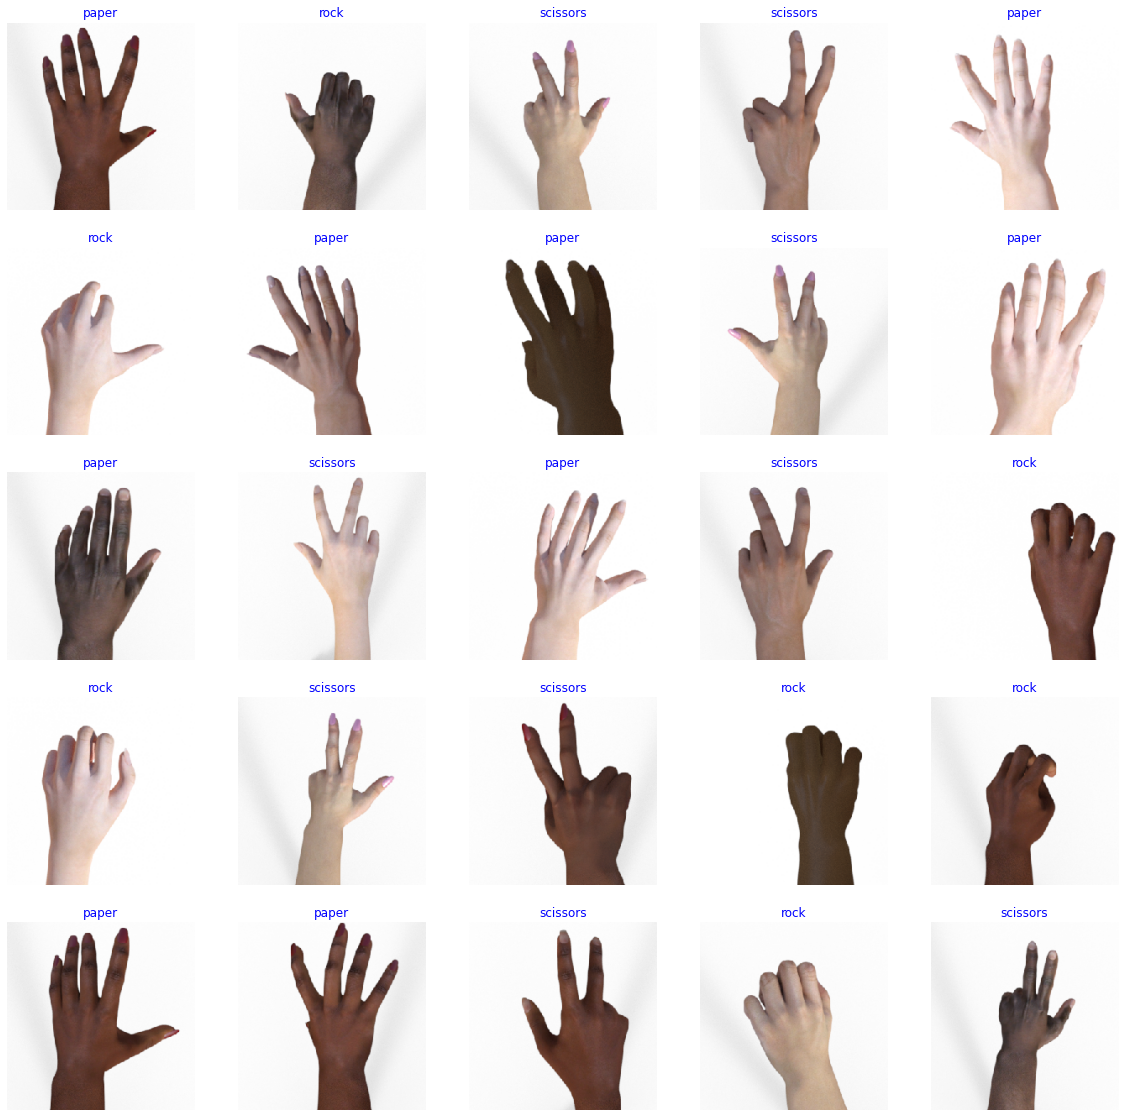

In [17]:
train_dir = input('Enter train data directory: ')
valid_dir = input('Enter validation data directory (if no valid dir press Enter): ')
test_dir = input('Enter test data directory (if no test dir press Enter): ')

try:
    # Get splitted data
    train_df, valid_df, test_df = split_data(train_dir, valid_dir, test_dir)

    # Get Generators
    batch_size = 40
    train_gen, valid_gen, test_gen = create_model_data(train_df, valid_df, test_df, batch_size)

    # Display Image Samples
    show_images(train_gen)

except:
    print('Invalid Input')

#### Generic Model Creation

In [18]:
# Get model from user
model_name = input('Enter Model Name: ')
model = chose_model(model_name)

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Enter Model Name:  efficientnetb3


2022-12-31 18:44:10.167601: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-31 18:44:10.275567: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-31 18:44:10.276398: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-31 18:44:10.278074: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

43950080/43941136 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb3 (Functional)  (None, 1536)              10783535  
_________________________________________________________________
batch_normalization (BatchNo (None, 1536)              6144      
_________________________________________________________________
dense (Dense)                (None, 256)               393472    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 771       
Total params: 11,183,922
Trainable params: 11,093,547
Non-trainable params: 90,375
_________________________________________________________________


#### Set Callback Parameters

In [19]:
batch_size = 40         # set batch size for training
epochs = 40             # number of all epochs in training
patience = 1            # number of epochs to wait to adjust lr if monitored value does not improve
stop_patience = 3       # number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.9         # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor = 0.5            # factor to reduce lr by
ask_epoch = 5           # number of epochs to run before asking if you want to halt training
batches = int(np.ceil(len(train_gen.labels) / batch_size))    # number of training batch to run per epoch

callbacks = [MyCallback(model= model, patience= patience,
            stop_patience= stop_patience, threshold= threshold, factor= factor,
            batches= batches, epochs= epochs, ask_epoch= ask_epoch )]

#### Train model

In [20]:
history = model.fit(x= train_gen, epochs= epochs, verbose= 0, callbacks= callbacks,
                    validation_data= valid_gen, validation_steps= None, shuffle= False)

Do you want model asks you to halt the training [y/n] ?


 y


 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration


2022-12-31 18:44:22.687713: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-12-31 18:44:36.874598: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


 1 /40     7.002   94.097   6.16708  97.024   0.00100  0.00100  val_loss     0.00    52.27  
 2 /40     5.054   99.454   4.51953  100.000  0.00100  0.00100  val_loss    26.72    28.06  
 3 /40     3.828   99.901   3.44540  100.000  0.00100  0.00100  val_loss    23.77    28.09  
 4 /40     3.007   99.901   2.69657  100.000  0.00100  0.00100  val_loss    21.73    28.41  
 5 /40     2.405   99.901   2.15608  100.000  0.00100  0.00100  val_loss    20.04    28.05  
enter H to halt training or an integer for number of epochs to run then ask again


 5


 training will continue until epoch 10
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 6 /40     1.952   100.000  1.75034  100.000  0.00100  0.00100  val_loss    18.82    28.30  
 7 /40     1.608   99.901   1.43110  100.000  0.00100  0.00100  val_loss    18.24    28.13  
 8 /40     1.320   99.950   1.17962  100.000  0.00100  0.00100  val_loss    17.57    28.63  
 9 /40     1.098   100.000  0.97930  100.000  0.00100  0.00100  val_loss    16.98    27.97  
10 /40     0.917   99.950   0.81646  100.000  0.00100  0.00100  val_loss    16.63    28.04  
enter H to halt training or an integer for number of epochs to run then ask again


 5


 training will continue until epoch 15
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
11 /40     0.765   99.950   0.67775  100.000  0.00100  0.00100  val_loss    16.99    28.03  
12 /40     0.650   99.851   0.57590  100.000  0.00100  0.00100  val_loss    15.03    27.89  
13 /40     0.565   100.000  0.48990  100.000  0.00100  0.00100  val_loss    14.93    28.10  
14 /40     0.480   99.950   0.42930  100.000  0.00100  0.00100  val_loss    12.37    30.99  
15 /40     0.415   100.000  0.36675  100.000  0.00100  0.00100  val_loss    14.57    28.15  
enter H to halt training or an integer for number of epochs to run then ask again


 5


 training will continue until epoch 20
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
16 /40     0.365   100.000  0.32038  100.000  0.00100  0.00100  val_loss    12.64    28.20  
17 /40     0.326   99.851   0.28490  100.000  0.00100  0.00100  val_loss    11.07    28.11  
18 /40     0.290   99.950   0.25442  100.000  0.00100  0.00100  val_loss    10.70    28.21  
19 /40     0.259   100.000  0.22672  100.000  0.00100  0.00100  val_loss    10.89    28.06  
20 /40     0.237   99.950   0.20494  100.000  0.00100  0.00100  val_loss     9.60    28.42  
enter H to halt training or an integer for number of epochs to run then ask again


 5


 training will continue until epoch 25
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
21 /40     0.212   100.000  0.18297  100.000  0.00100  0.00100  val_loss    10.72    28.27  
22 /40     0.196   100.000  0.17098  100.000  0.00100  0.00100  val_loss     6.56    28.17  
23 /40     0.182   100.000  0.15522  100.000  0.00100  0.00100  val_loss     9.22    28.33  
24 /40     0.170   100.000  0.14394  100.000  0.00100  0.00100  val_loss     7.26    28.04  
25 /40     0.157   100.000  0.13358  100.000  0.00100  0.00100  val_loss     7.20    28.19  
enter H to halt training or an integer for number of epochs to run then ask again


 h


training has been halted at epoch 25 due to user input
training elapsed time was 0.0 hours, 14.0 minutes, 51.87 seconds)


#### Display model performance

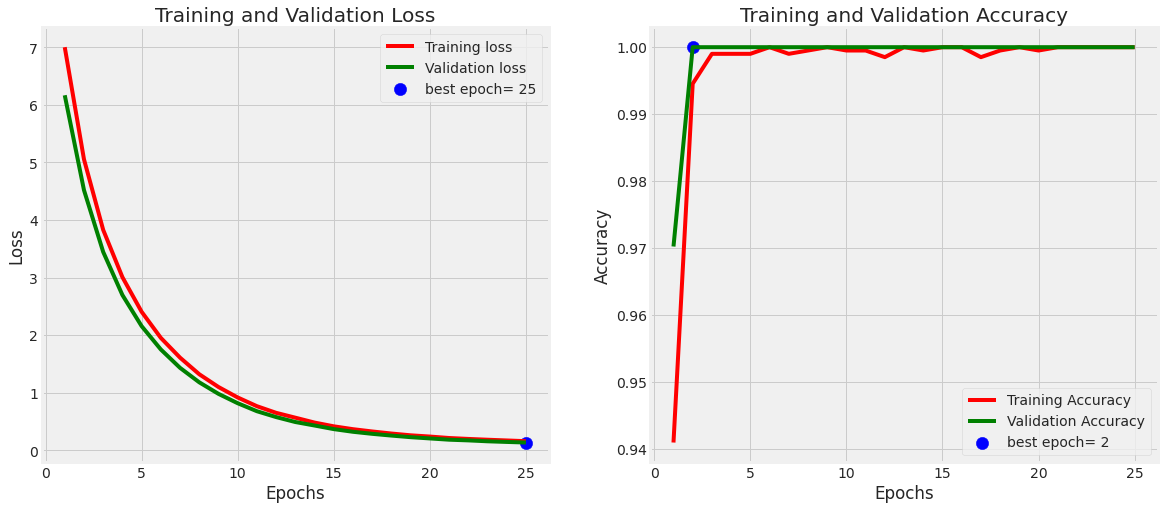

In [21]:
plot_training(history)

### Evaluate model

In [22]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

35/35 [==============================] - 13s 364ms/step - loss: 0.1335 - accuracy: 1.0000
Train Loss:  0.13336966931819916
Train Accuracy:  1.0
--------------------
Validation Loss:  0.13357558846473694
Validation Accuracy:  1.0
--------------------
Test Loss:  0.13347312808036804
Test Accuracy:  1.0


# Get Predictions

In [23]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

[0 0 0 ... 2 2 2]


#### Confusion Matrics and Classification Report

Confusion Matrix, Without Normalization
[[840   0   0]
 [  0 840   0]
 [  0   0 840]]
              precision    recall  f1-score   support

       paper       1.00      1.00      1.00       840
        rock       1.00      1.00      1.00       840
    scissors       1.00      1.00      1.00       840

    accuracy                           1.00      2520
   macro avg       1.00      1.00      1.00      2520
weighted avg       1.00      1.00      1.00      2520



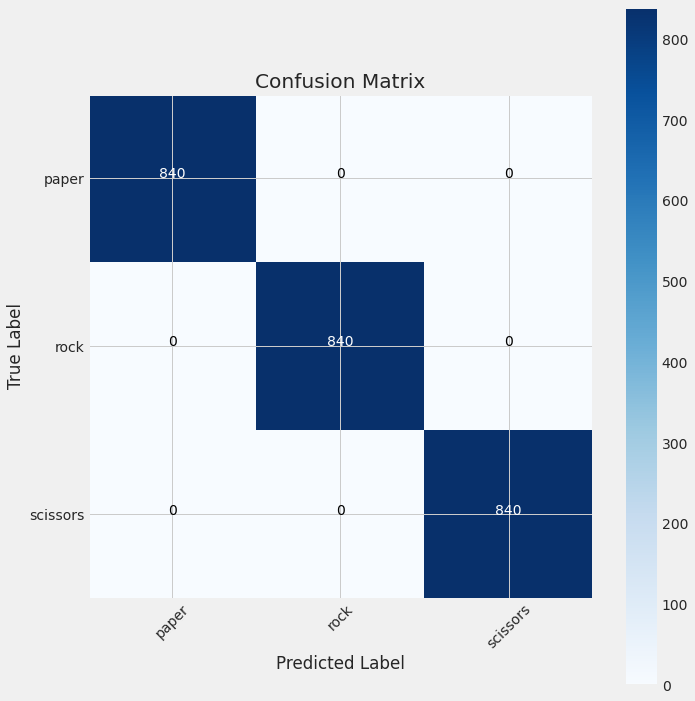

In [24]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix')

# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

# Save model

In [25]:
model_name = model.input_names[0][:-6]
subject = input('Enter Project Subject')
acc = test_score[1] * 100
save_path = ''

# Save model
save_id = str(f'{model_name}-{subject}-{"%.2f" %round(acc, 2)}.h5')
model_save_loc = os.path.join(save_path, save_id)
model.save(model_save_loc)
print(f'model was saved as {model_save_loc}')

# Save weights
weight_save_id = str(f'{model_name}-{subject}-weights.h5')
weights_save_loc = os.path.join(save_path, weight_save_id)
model.save_weights(weights_save_loc)
print(f'weights were saved as {weights_save_loc}')

Enter Project Subject Rock-Paper-Scissors


model was saved as efficientnetb3-Rock-Paper-Scissors-100.00.h5
weights were saved as efficientnetb3-Rock-Paper-Scissors-weights.h5


### Generate CSV files containing classes indicies & image size 

In [26]:
class_dict = train_gen.class_indices
img_size = train_gen.image_shape
height = []
width = []
for _ in range(len(class_dict)):
    height.append(img_size[0])
    width.append(img_size[1])

Index_series = pd.Series(list(class_dict.values()), name= 'class_index')
Class_series = pd.Series(list(class_dict.keys()), name= 'class')
Height_series = pd.Series(height, name= 'height')
Width_series = pd.Series(width, name= 'width')
class_df = pd.concat([Index_series, Class_series, Height_series, Width_series], axis= 1)
csv_name = f'{subject}-class_dict.csv'
csv_save_loc = os.path.join(save_path, csv_name)
class_df.to_csv(csv_save_loc, index= False)
print(f'class csv file was saved as {csv_save_loc}')

class csv file was saved as Rock-Paper-Scissors-class_dict.csv
